## Part IV.3: Experiments with Transformer and Stacked Convolutional Transformer (SCT) Model Architectures

In this section, experiments and tuning exercises will be conducted using Transformer foundational model  and SCT architecture.  This will include the following:

1.  Experiments with different depths of Transformer model architectures (number of encoder layers, etc.)
2.  Experiments with configuration of SCT architectures (number of encoder layers, etc.)
3.  SCT model optimization with tuning job

In [ ]:
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras import layers
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay

### Load Prepared Datasets

In [ ]:
LOAD_FROM_GDRIVE = True
DATASET_KEY = "48_6"

In [ ]:
if(LOAD_FROM_GDRIVE):
    # mount google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')

    dataset_root = '/content/drive/MyDrive/Datasets/sepsis/prepared/'

    X_train = np.load(os.path.join(dataset_root, 'X_train.npy'))
    y_train = np.load(os.path.join(dataset_root, 'y_train.npy'))

    X_test = np.load(os.path.join(dataset_root, 'X_test.npy'))
    y_test = np.load(os.path.join(dataset_root, 'y_test.npy'))

    X_val =  np.load(os.path.join(dataset_root, 'X_val.npy'))
    y_val = np.load(os.path.join(dataset_root, 'y_val.npy'))

else:
    # load from datalake (S3)
    !aws s3 cp $s3_datalake_path_prepared $local_data_path_csv --recursive --exclude "*" --include "*.npy"

    X_train = np.load(os.path.join(local_data_path_csv, 'X_train.npy'))
    y_train = np.load(os.path.join(local_data_path_csv, 'y_train.npy'))

    X_test = np.load(os.path.join(local_data_path_csv, 'X_test.npy'))
    y_test = np.load(os.path.join(local_data_path_csv, 'y_test.npy'))

    X_val =  np.load(os.path.join(local_data_path_csv, 'X_val.npy'))
    y_val = np.load(os.path.join(local_data_path_csv, 'y_val.npy'))

Mounted at /content/drive


In [ ]:
# inspect the loaded data
print(f"Train data shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Test data shape: X: {X_test.shape}, y: {y_test.shape}")
print(f"Validation data shape: X: {X_val.shape}, y: {y_val.shape}")

Train data shape: X: (3105, 48, 51), y: (3105,)
Test data shape: X: (388, 48, 51), y: (388,)
Validation data shape: X: (389, 48, 51), y: (389,)


In [ ]:
# refactor targets to work for modeling
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [ ]:
# global default training parameters
NUM_EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
input_shape = X_train.shape[1:]

# calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.reshape(-1,))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6933899062081287, 1: 1.7927251732101617}

### Helper Functions for Training Experiements

In [ ]:
# define function to generate an encoder unit (ref: https://keras.io/examples/timeseries/timeseries_classification_transformer/)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def transformer_encoder_lff(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Dense(256, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# define function to build model with configurable settings (ref: https://keras.io/examples/timeseries/timeseries_classification_transformer/)
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    lff=False
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        if(lff):
            x = transformer_encoder_lff(x, head_size, num_heads, ff_dim, dropout)
        else:
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

def build_hybrid_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    lff=False
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # convolutional module
    x = layers.Conv1D(filters=128, kernel_size=3, padding='causal', kernel_regularizer = tf.keras.regularizers.l1(0.01))(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    skip1 = x

    # depth wise conv layer
    x = layers.DepthwiseConv1D(kernel_size=3, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = x + skip1


    # max pooling
    x = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(x)
    x = layers.Dropout(dropout)(x)
    skip2 = x

    # spatial convolution layer
    x = layers.Conv1D(filters=128, kernel_size=3, padding='causal', kernel_regularizer = tf.keras.regularizers.l1(0.01))(x)
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)
    x = x + skip2

    # max pooling
    x = layers.MaxPooling1D(pool_size=2, strides=2, padding="same")(x)
    x = layers.Dropout(dropout)(x)

    # transformer module
    for _ in range(num_transformer_blocks):
        if(lff):
            x = transformer_encoder_lff(x, head_size, num_heads, ff_dim, dropout)
        else:
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # fully connected classifier module
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# compile and train model
def compile_and_train_adam(model, checkpoint_callback):
  # Compile the model
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
  )
  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights, callbacks=[checkpoint_callback])
  return history

# plot loss curves
def plot_loss(history, title, ignore_first=False):
  start_idx = 0
  if(ignore_first):
    start_idx = 1

  plt.plot(history.history['loss'][start_idx:])
  plt.plot(history.history['val_loss'][start_idx:])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Tain', 'Val'])
  plt.show()

# run forward pass and plot confusion matrix
def predict_and_plot_confusion(model, X, y, title):
  y_pred = model.predict(X)
  cm = confusion_matrix(y, np.round(y_pred).tolist())
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  plt.title(title)

# run forward pass and print metrics
def predict_and_print_metrics(model, X, y):
  results = model.evaluate(X, y, batch_size=BATCH_SIZE)
  print(f"Loss: {results[0]}")
  print(f"Binary Accuracy: {results[1]}")
  print(f"Precision: {results[2]}")
  print(f"Recall: {results[3]}")

def run_experiment(model, title, ignore_first=False):
  # train the model
  callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)]
  model_history = compile_and_train_adam(model, callbacks)

  #plot loss
  plot_loss(model_history, title + ' - Train/Val Loss', True)

  # confusion matrix
  predict_and_plot_confusion(model, X_val, y_val, "Confusion Matrix - " + title)

  # forward pass
  predict_and_print_metrics(model, X_val, y_val)


### Baseline Experiement

In [ ]:
# define baseline model
baseline_xformer = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

# train the model
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)]
baseline_history = compile_and_train_adam(baseline_xformer, callbacks)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 419ms/step - binary_accuracy: 0.6374 - f1_score: 0.4326 - loss: 0.7761 - precision_3: 0.3973 - recall_3: 0.6154 - val_binary_accuracy: 0.7506 - val_f1_score: 0.4090 - val_loss: 0.5359 - val_precision_3: 0.5105 - val_recall_3: 0.7300
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - binary_accuracy: 0.7842 - f1_score: 0.4375 - loss: 0.4989 - precision_3: 0.5904 - recall_3: 0.7483 - val_binary_accuracy: 0.7404 - val_f1_score: 0.4090 - val_loss: 0.5614 - val_precision_3: 0.4969 - val_recall_3: 0.7900
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.8091 - f1_score: 0.4481 - loss: 0.4667 - precision_3: 0.6395 - recall_3: 0.7796 - val_binary_accuracy: 0.8226 - val_f1_score: 0.4090 - val_loss: 0.4514 - val_precision_3: 0.6202 - val_recall_3: 0.8000
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_accuracy: 0.8492 - f1_score: 0.4355 - loss: 0.4105 - precision_3: 0.6926 - recall_3: 0.8233 - val_binary_accuracy: 

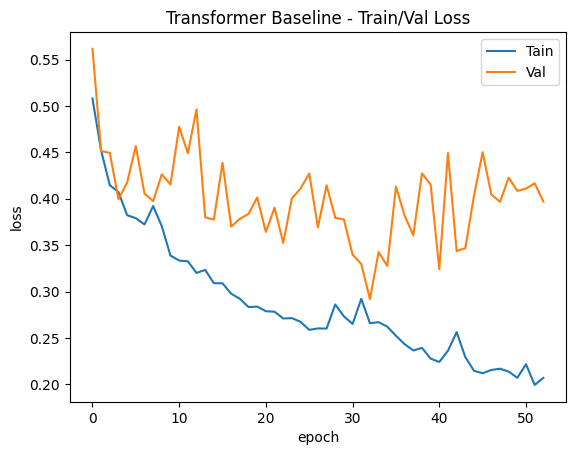

In [ ]:
#plot loss
plot_loss(baseline_history, 'Transformer Baseline - Train/Val Loss', True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step


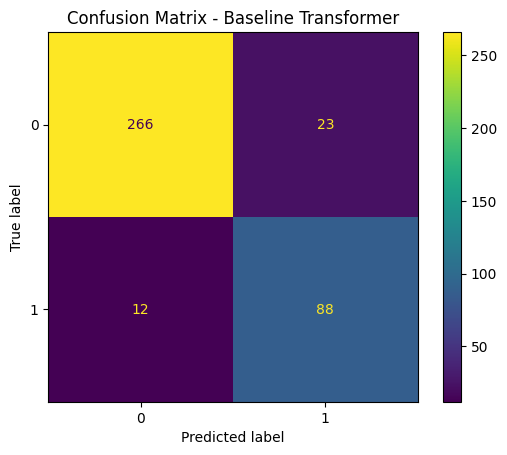

In [ ]:
predict_and_plot_confusion(baseline_xformer, "Confusion Matrix - Baseline Transformer")

In [ ]:
results = baseline_xformer.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(f"Loss: {results[0]}")
print(f"Binary Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")
print(f"F1 Score: {results[4]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.9124 - f1_score: 0.3978 - loss: 0.2969 - precision_3: 0.7914 - recall_3: 0.8792
Loss: 0.2919168174266815
Binary Accuracy: 0.9100257158279419
Precision: 0.792792797088623
Recall: 0.8799999952316284
F1 Score: 0.40899792313575745


In [ ]:
# save baseline model
baseline_xformer.save('/content/drive/MyDrive/Datasets/sepsis/models/xformer_baseline.keras')

### Transformer Experiment 1: Increase Number of Encoders

In [ ]:
# define baseline model
input_shape = X_train.shape[1:]
xformer_e1 = build_model(
    input_shape,
    head_size=512,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.3,
)

# train the model
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)]
xformer_e1_history = compile_and_train_adam(xformer_e1, callbacks)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 90s 855ms/step - binary_accuracy: 0.6343 - f1_score: 0.4409 - loss: 0.8967 - precision_5: 0.3981 - recall_5: 0.5908 - val_binary_accuracy: 0.7686 - val_f1_score: 0.4090 - val_loss: 0.5434 - val_precision_5: 0.5397 - val_recall_5: 0.6800
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - binary_accuracy: 0.7503 - f1_score: 0.4412 - loss: 0.5291 - precision_5: 0.5430 - recall_5: 0.7758 - val_binary_accuracy: 0.8278 - val_f1_score: 0.4090 - val_loss: 0.4517 - val_precision_5: 0.6701 - val_recall_5: 0.6500
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - binary_accuracy: 0.8131 - f1_score: 0.4431 - loss: 0.4684 - precision_5: 0.6359 - recall_5: 0.8010 - val_binary_accuracy: 0.8612 - val_f1_score: 0.4090 - val_loss: 0.4011 - val_precision_5: 0.8108 - val_recall_5: 0.6000
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - binary_accuracy: 0.8179 - f1_score: 0.4387 - loss: 0.4658 - precision_5: 0.6539 - recall_5: 0.7501 - val_binary_accuracy: 

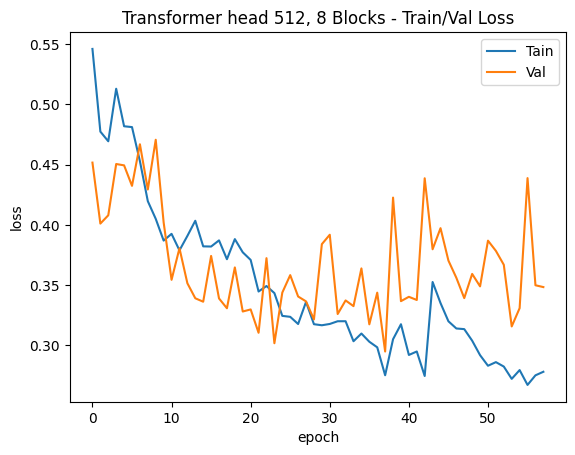

In [ ]:
#plot loss
plot_loss(xformer_e1_history, 'Transformer head 512, 8 Blocks - Train/Val Loss', True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step


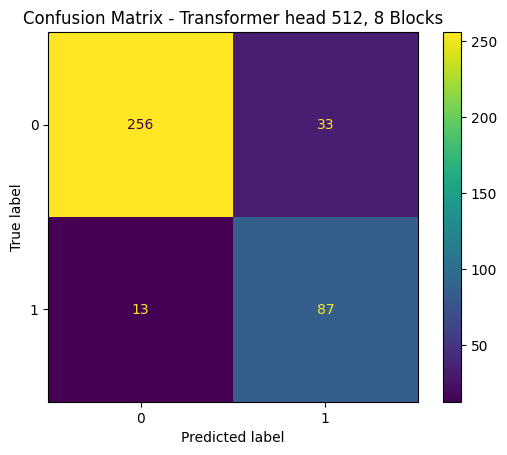

In [ ]:
predict_and_plot_confusion(xformer_e1, "Confusion Matrix - Transformer head 512, 8 Blocks")

In [ ]:
results = xformer_e1.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(f"Loss: {results[0]}")
print(f"Binary Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")
print(f"F1 Score: {results[4]}")

In [ ]:
# save baseline model
xformer_e1.save('/content/drive/MyDrive/Datasets/sepsis/models/xformer_e1.keras')

### Transformer Experiment 2: LSTM as Feed-Forward Units

Epoch 1/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - binary_accuracy: 0.6601 - f1_score: 0.4434 - loss: 0.6989 - precision_3: 0.4374 - recall_3: 0.6447 - val_binary_accuracy: 0.8098 - val_f1_score: 0.4090 - val_loss: 0.4503 - val_precision_3: 0.5903 - val_recall_3: 0.8500
Epoch 2/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 82ms/step - binary_accuracy: 0.7965 - f1_score: 0.4489 - loss: 0.4698 - precision_3: 0.6177 - recall_3: 0.7892 - val_binary_accuracy: 0.8612 - val_f1_score: 0.4090 - val_loss: 0.4149 - val_precision_3: 0.6983 - val_recall_3: 0.8100
Epoch 3/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - binary_accuracy: 0.8616 - f1_score: 0.4450 - loss: 0.3896 - precision_3: 0.7358 - recall_3: 0.8087 - val_binary_accuracy: 0.8843 - val_f1_score: 0.4090 - val_loss: 0.3452 - val_precision_3: 0.7619 - val_recall_3: 0.8000
Epoch 4/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - binary_accuracy: 0.8758 - f1_score: 0.4241 - loss: 0.3421 - precision_3: 0.7343 - recall_3: 0.8437 - val_binary_accuracy: 0

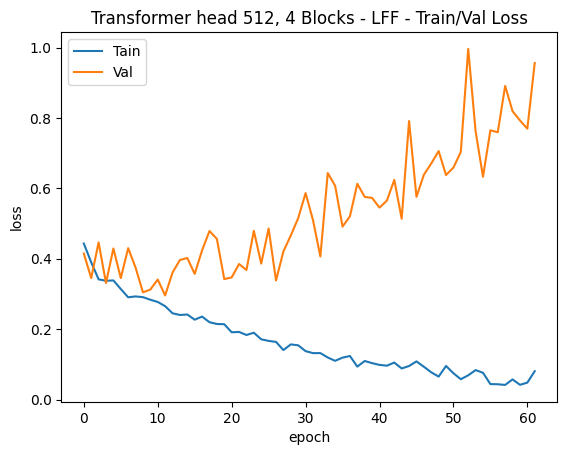

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.9040 - f1_score: 0.3978 - loss: 0.2670 - precision_3: 0.7839 - recall_3: 0.8485
Loss: 0.29586365818977356
Binary Accuracy: 0.8946015238761902
Precision: 0.7657657861709595
Recall: 0.8500000238418579
F1 Score: 0.40899792313575745


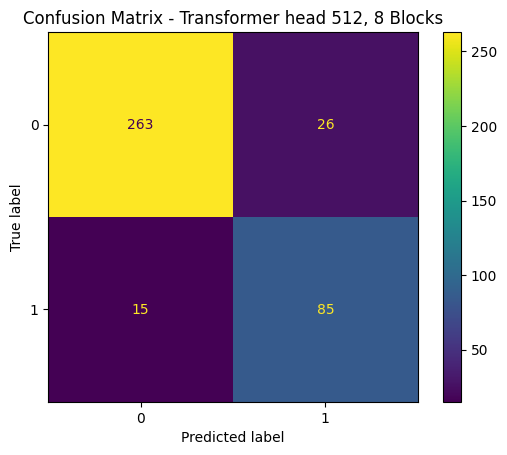

In [ ]:
# define baseline model
input_shape = X_train.shape[1:]
xformer_lff1 = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=8,
    num_transformer_blocks=8,
    mlp_units=[512],
    mlp_dropout=0.2,
    dropout=0.3,
    lff=True
)

# run experiment
run_experiment(xformer_lff1, "Transformer head 512, 4 Blocks - LFF")

### Experiment 3: Hybrid CNN + Transformer (SCT)

Epoch 1/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 50s 443ms/step - binary_accuracy: 0.5724 - f1_score: 0.4396 - loss: 32.9090 - precision_4: 0.3462 - recall_4: 0.5552 - val_binary_accuracy: 0.5707 - val_f1_score: 0.4090 - val_loss: 31.0007 - val_precision_4: 0.3498 - val_recall_4: 0.7800
Epoch 2/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - binary_accuracy: 0.7163 - f1_score: 0.4364 - loss: 30.4442 - precision_4: 0.4945 - recall_4: 0.6940 - val_binary_accuracy: 0.7558 - val_f1_score: 0.4090 - val_loss: 28.9726 - val_precision_4: 0.5210 - val_recall_4: 0.6200
Epoch 3/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - binary_accuracy: 0.7543 - f1_score: 0.4442 - loss: 28.5437 - precision_4: 0.5582 - recall_4: 0.7272 - val_binary_accuracy: 0.7995 - val_f1_score: 0.4090 - val_loss: 27.0972 - val_precision_4: 0.6038 - val_recall_4: 0.6400
Epoch 4/500
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - binary_accuracy: 0.7561 - f1_score: 0.4365 - loss: 26.6515 - precision_4: 0.5476 - recall_4: 0.7409 - val_binary_acc

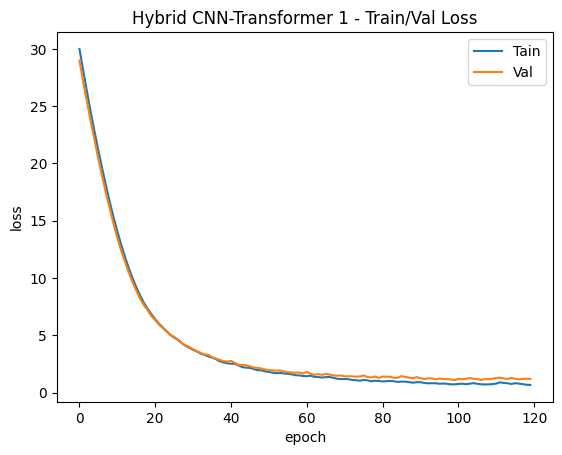

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.8950 - f1_score: 0.3978 - loss: 1.0736 - precision_4: 0.7642 - recall_4: 0.8359 
Loss: 1.096929669380188
Binary Accuracy: 0.8894601464271545
Precision: 0.7614678740501404
Recall: 0.8299999833106995
F1 Score: 0.40899792313575745


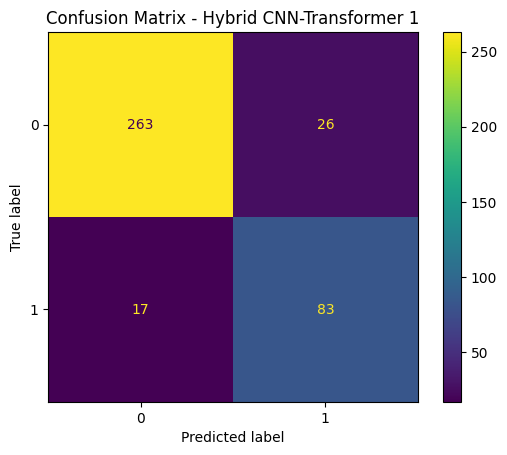

In [ ]:
# define baseline model
input_shape = X_train.shape[1:]
xformer_hybrid1 = build_hybrid_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    lff=False
)

# run experiment
run_experiment(xformer_hybrid1, "Hybrid CNN-Transformer 1")

In [ ]:
# print model summary
xformer_hybrid1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 48, 51)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_62 (Conv1D)        │ (None, 48, 128)        │         19,712 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_32 (ReLU)           │ (None, 48, 128)        │              0 │ conv1d_62[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 48, 128)        │            512 │ re_lu_32[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv1d_12       │ (None, 48, 128)        │            512 │ batch_normalization_3… │
│ (DepthwiseConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_33 (ReLU)           │ (None, 48, 128)        │              0 │ depthwise_conv1d_12[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 48, 128)        │            512 │ re_lu_33[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_56 (Add)              │ (None, 48, 128)        │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_14          │ (None, 24, 128)        │              0 │ add_56[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_79 (Dropout)      │ (None, 24, 128)        │              0 │ max_pooling1d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_63 (Conv1D)        │ (None, 24, 128)        │         49,280 │ dropout_79[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_34 (ReLU)           │ (None, 24, 128)        │              0 │ conv1d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 24, 128)        │            512 │ re_lu_34[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_57 (Add)              │ (None, 24, 128)        │              0 │ batch_normalization_3… │
│                           │                        │                │ dropout_79[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_15          │ (None, 12, 128)        │              0 │ add_57[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├──────────────────────

 Total params: 6,611,381 (25.22 MB)

 Trainable params: 2,203,537 (8.41 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 4,407,076 (16.81 MB)

In [ ]:
# save baseline model
xformer_hybrid1.save('/content/drive/MyDrive/Datasets/sepsis/models/xformer_cnn_hybrid1.keras')

### Experiment 4: SCT Hybrid CNN + Transformer (24 hr. look back)

Epoch 1/500
306/306 ━━━━━━━━━━━━━━━━━━━━ 45s 61ms/step - binary_accuracy: 0.6758 - f1_score: 0.1270 - loss: 30.9519 - precision_1: 0.1298 - recall_1: 0.6547 - val_binary_accuracy: 0.8640 - val_f1_score: 0.1273 - val_loss: 24.5406 - val_precision_1: 0.2804 - val_recall_1: 0.6386
Epoch 2/500
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - binary_accuracy: 0.7728 - f1_score: 0.1210 - loss: 23.0607 - precision_1: 0.1772 - recall_1: 0.6937 - val_binary_accuracy: 0.8939 - val_f1_score: 0.1273 - val_loss: 18.3240 - val_precision_1: 0.3465 - val_recall_1: 0.6325
Epoch 3/500
306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - binary_accuracy: 0.8108 - f1_score: 0.1197 - loss: 17.2067 - precision_1: 0.2072 - recall_1: 0.6865 - val_binary_accuracy: 0.8197 - val_f1_score: 0.1273 - val_loss: 13.9368 - val_precision_1: 0.2385 - val_recall_1: 0.7530
Epoch 4/500
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - binary_accuracy: 0.8090 - f1_score: 0.1251 - loss: 13.0982 - precision_1: 0.2212 - recall_1: 0.7246 - val_bin

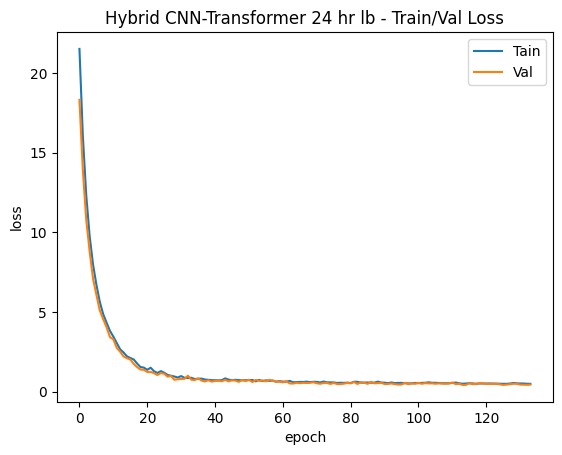

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9214 - f1_score: 0.1257 - loss: 0.4230 - precision_1: 0.4460 - recall_1: 0.7366
Loss: 0.43063390254974365
Binary Accuracy: 0.9135600328445435
Precision: 0.41992881894111633
Recall: 0.7108433842658997
F1 Score: 0.1274472028017044


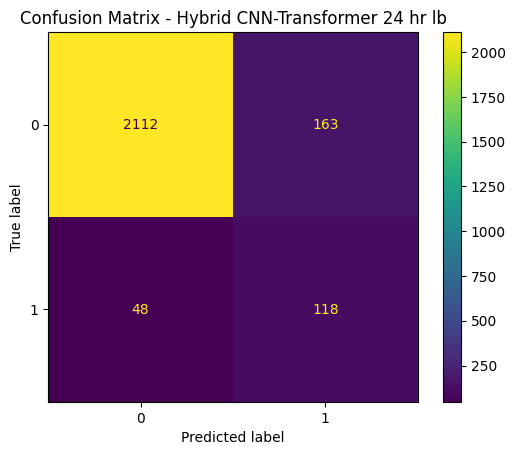

In [ ]:
# define baseline model
input_shape = X_train.shape[1:]
xformer_hybrid2 = build_hybrid_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    lff=False
)

# run experiment
run_experiment(xformer_hybrid2, "Hybrid CNN-Transformer 24 hr lb")

## Run Tuning Job on Stacked Convolutional Transformer (SCT) Using Hyper-Model

### Helper function for Tuning Job

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
# build and compile model with tuner hyperparameters
def build_hyper_model(hp):

    K.clear_session()

    hp_head_size = hp.Int("head_size", min_value=64, max_value=512, step=32)
    hp_num_heads = hp.Int("num_heads", min_value=4, max_value=32, step=4)
    hp_ff_dim = hp.Int("ff_dim", min_value=4, max_value=32, step=4)
    hp_num_transformer_blocks = hp.Int("num_transformer_blocks", min_value=1, max_value=16, step=1)
    hp_mlp_units = hp.Int("mlp_units", min_value=32, max_value=512, step=32)
    hp_mlp_dropout = hp.Float("mlp_dropout", min_value=0.1, max_value=0.4, step=0.1)
    hp_dropout = hp.Float("dropout", min_value=0.05, max_value=0.4, step=0.05)

    dropout = hp.Boolean("dropout")

    model = build_hybrid_model(
        input_shape,
        head_size=hp_head_size,
        num_heads=hp_num_heads,
        ff_dim=hp_ff_dim,
        num_transformer_blocks=hp_num_transformer_blocks,
        mlp_units=[hp_mlp_units],
        mlp_dropout=hp_mlp_dropout,
        dropout=hp_dropout,
        lff=False
    )

    # compile parameters
    hp_lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    # Compile the model
    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
    )

    return model


In [ ]:
hybrid_tuner = kt.RandomSearch(
    hypermodel=build_hyper_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=25,
    executions_per_trial=1,
    overwrite=True,
    directory="/content/drive/MyDrive/Datasets/sepsis/models",
    project_name="hybrid_transformer_tuner",
)

tuner_callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)]

In [ ]:
hybrid_tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=75,
    batch_size=64,
    class_weight=class_weights,
    callbacks=tuner_callbacks)

Trial 25 Complete [00h 03m 53s]
val_loss: 0.4866480231285095

Best val_loss So Far: 0.44667595624923706
Total elapsed time: 01h 35m 18s


In [ ]:
# get the best models
models = hybrid_tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 514 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 51)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 48, 128)        │         19,712 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 48, 128)        │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 48, 128)        │            512 │ re_lu[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv1d          │ (None, 48, 128)        │            512 │ batch_normalization[0… │
│ (DepthwiseConv1D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 48, 128)        │              0 │ depthwise_conv1d[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 48, 128)        │            512 │ re_lu_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 48, 128)        │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 24, 128)        │              0 │ add[0][0]              │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 24, 128)        │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 24, 128)        │         49,280 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 24, 128)        │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 24, 128)        │            512 │ re_lu_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 24, 128)        │              0 │ batch_normalization_2… │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 12, 128)        │              0 │ add_1[0][0]            │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 27,904,801 (106.45 MB)

 Trainable params: 27,904,033 (106.45 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# save best model
best_model.save('/content/drive/MyDrive/Datasets/sepsis/models/xformer_cnn_tuned.keras')

In [ ]:
# load if necessary
best_model = keras.models.load_model('/content/drive/MyDrive/Datasets/sepsis/models/xformer_cnn_tuned.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 514 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


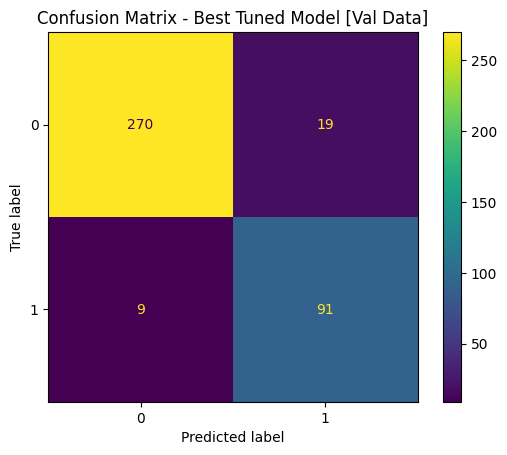

In [ ]:
# get metrics for model on val data
predict_and_plot_confusion(best_model, X_val, y_val, "Confusion Matrix - Best Tuned Model [Val Data]")

In [ ]:
# get metrics
predict_and_print_metrics(best_model, X_val, y_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - binary_accuracy: 0.9269 - loss: 0.4533 - precision: 0.8171 - recall: 0.9086
Loss: 0.44667595624923706
Binary Accuracy: 0.9280205368995667
Precision: 0.8272727131843567
Recall: 0.9100000262260437


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


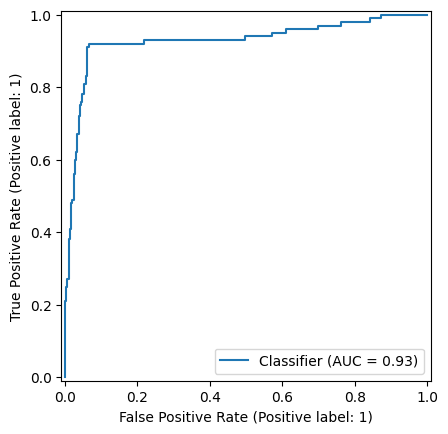

In [ ]:
# calc AUC ROC
y_pred_val = best_model.predict(X_val)
RocCurveDisplay.from_predictions(y_val, y_pred_val)